<a href="https://colab.research.google.com/github/JYP0824/paper/blob/main/%5Bpaper%5DAttention_is_all_you_need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

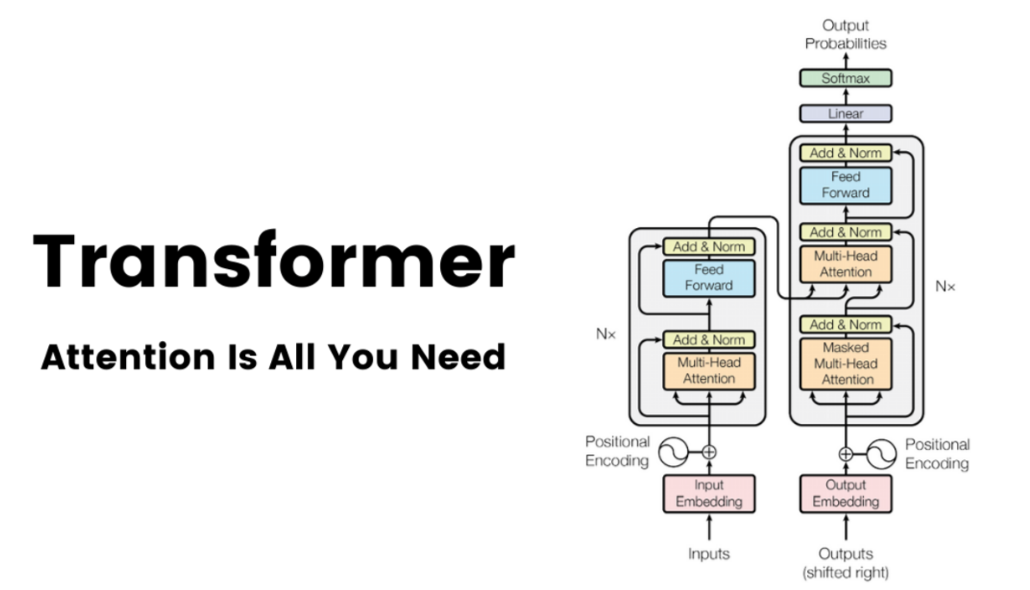

# Transformer

### Before transformer

RNN, LSTM을 이용한 Seq2Seq 혹은 CNN을 이용한 모델을 사용하였는데, RNN, LSTM을 이용한 Seq2Seq 모델은 모든 입력 seqeuence를 순차적으로 받아 하나의 context vector로 압축하는데, 입력 sequence의 길이가 길어짐에 따라 초기 입력에 대한 정보가 사라지는 **Vanishing Gradient** 문제가 있었다

sequential하게 입력을 받는 모델 구조 특성상 병렬 계산을 수행하는 GPU의 이점을 완벽히 받을 수 없었으며, 입력과 출력을 제대로 연관짓지 못하는 문제(dependency)가 있었다.

해당 단점들을 극복하기 위해 Seq2Seq 구조에 attention mechanism을 결합한 구조가 고안되었으나, recurrent 구조의 한계로 모든 문제를 해결할 수는 없었다. 이에 따라 recurrent 구조를 완전히 제거하고, attention만을 사용한 Transformer가 나오게 되었다.

Transformer는 이전의 recurrent 구조를 사용하지 않고, attention mechanism만을 사용한 모델으로, 입력을 parallel하게 받는다. 이에 따라 기존의 recurrent 구조의 모델의 sequential한 특성으로 인해 GPU를 완전히 사용하지 못하던 단점을 보완하였다.

또한, encoder, decoder로 이루어져 있으며, 내부에서 self-attention을 수행하기 때문에 dependency 문제를 해결하였다. 따라서 문장 내 모든 단어쌍 사이의 곤계를 전체적으로 파악할 수 있다.

하지만, 입력을 parallel하게 받기 때문에 입력 token들의 순서 정보를 갖고 있지 않아 순서 정보를 추가하는 작업( **positional encoding** )이 추가로 수행되었다.

# Encoder

Encoder는 input과 같은 shape를 가진 token들로 구성된 context vector( representation이 높아진 상태 )를 출력한다

In [ ]:
import torch
import math
import torch.nn as nn

##Positional Encoding

Transformer는 recurrent 구조를 갖는 모델들과 달리 입력 sequence에 따라 순서를 고려해 입력이 들어오지 않기 때문에 position에 대한 정보 추가가 필요하다. Position 정보가 추가되지 않을 경우 모델의 입력 sequence가 단어의 순서가 달라진 채 들어오게 되더라도, 모델은 같은 입력으로 인식하게 되어, attention의 결과가 같게 나온다.

따라서 매 sequence마다 서로 다른 unique한 값을 갖는 벡터를 만들어 입력 벡터에 더해주는 과정을 수행하게 되는데, 일반적으로 position마다 서로 다른 sin, cos 주기를 만들어 더해주게 된다.

**sinusoidal함수를 사용하는 이유**



*   각 token의 위치를 확인하기 위함이며, sinusoidal함수는 -1~1 사이의 값으로 position 별 unique한 정보를 부여할 수 있기 때문
*   주기함수의 frequency를 다양하게 주어 겹칠 가능성이 낮기 때문



In [ ]:
class PE(nn.Module):
  def __init__(self, seq_len, d_model):
    super(PE, self).__init__()

    self.encoding = torch.zeros(seq_len, d_model, device=device)
    encoding.requires_grad=False

    pos = torch.arange(0,seq_len, device=device)
    pos = pos.float().unsqueeze(dim=1)

    _2i = torch.arange(0, d_model, step=2, dvice=device)

    encoding[:,0::2] = torch.cos(pos/10000**(_2i/d_model))
    encoding[:,1::2] = torch.sin(pos/10000**(_2i/d_model))

  def forward(self, x):
    batch_size, seq_len  = x.size()
    return encoding[:seq_len, :]

## Self-attention

같은 입력이 서로 다른 값을 가진 Weight와 행렬곱을 통해 Q, K, V를 구하는데, 입력보다 작은 차원을 가진다.

*   (seq_len, dk),  dk = dmodel / num_head


작은 차원을 사용하는 이유는 필요한 파라미터 수를 줄이고, 동시에 다양한 정보를 파악하기 위함이다

결과적으로 동일한 input vector set 내에서 내적과 가중평균의 attention 계산 과정이 이루어진다는 의미에서 이를 'self-attention' 모듈이라고 부른다.

그러나 위에서 설명한 것처럼 input vector set을 그대로 내적을 계산하게 되면, 현재 보고 있는 단어인 자기 자신에 관해 내적을 수행한 유사도가 서로 다른 벡터와의 유사도를 구한 것보다 일반적으로 큰 값을 갖는 경향을 띠게 된다.

이렇게 될 경우 출력으로 내보낸 인코딩된 단어 vector도 자기 자신에 관한 원래 정보를 더 많이 포함되도록 나올 것이다.

이러한 기본적인 형태의 attention 모듈 작동 과정을 사용한 것에서 그치지 않고 유연하게 확장하여 위에서의 문제를 개선하고자 하는 모델이 바로 'Attention is all you need'에서 제안된 transformer이다.

각 단어에 대응되는 동일한 input vector가 attention 모듈 계산 과정의 각 단계마다 서로 다른 역할을 하는 것을 알 수 있었다. 그런데 이는 앞서 정리한 바처럼 자기 자신에 관한 attention을 높이게 하는 단점을 지니고 있다.

그래서 논문에서는 각각의 역할을 하는 vector들을 input vector로 모두 동일하게 사용하는 방법이 아니라,역할마다 서로 다른 벡터 query, key, value vector를 사용하여 학습을 수행하는 방법을 제시하였다.

마지막으로, query vector와 key vector 간의 유사도를 구한 것 중에서 어떠한 key vector와 내적할 때 높은 유사도를 지니는지 구한 결과에 softmax를 취하여 최종적으로 어떠한 단어에 주목할지에 관한 가중치를 얻는다.

Transformer에서는 여기서도 Attention 모듈에서와는 달리 가중 평균을 구할 때 각 단어별로 임베딩된 input vector를 그대로 사용하지 않고 각 단어별 value vector를 사용한다.

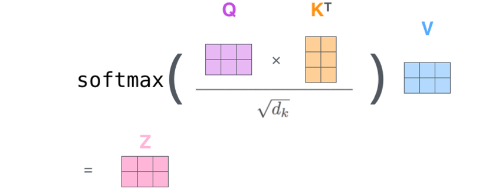

단어별로 모든 역할에 관해 제한적으로 동일한 벡터를 사용하지 않고 역할에 따라 query, key, value vector로 쓰일 때 다른 형태로 사용될 수 있도록 했으며, 동일한 단어에 관한 input vector로부터 변환된 query와 key vector를 내적해도 반드시 유사도가 가장 높은 값이 나오지는 않는 유연성의 효과를 얻는다.

이러한 transformer의 특징으로 인해 모델의 입력으로 주어지는 단어의 개수만큼 각각 key, value vector를 갖게 된다.이론적으로 반드시 query vector 수가 단어의 수와 같아야 하는 것은 아니지만, 실제 transformer 구현상에서는 query vector도 입력으로 주어진 단어의 수만큼 갖는다.

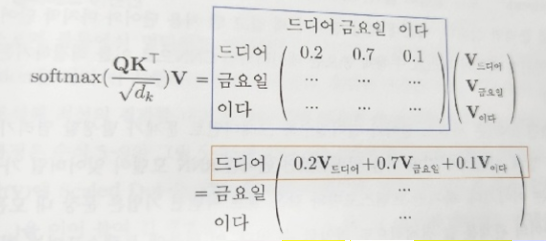

파란 선으로 둘러싸인 행렬은 Q, K의 행렬 곱 이후, root(dk)로 나누어진 뒤 소프트맥스가 취해진 결과로, Q의 각 단어에 적용될 서로 다른 sequence 단어들에 대한 기여도를 의미하며, 이를 self-attention이라 한다

Q, K의 행렬곱으로 구해진 현재 관점에서 두 단어 사이의 관련성에 해당되는 attention score에 scaling이 이루어지는 이유는 분산을 줄여 softmax하였을 때 특정 값이 지나치게 작아지는 것을 방지하기 위함이다.

두 벡터의 내적은 벡터 사이의 유사도를 구하는 가장 보편적인 방법이다. Q, K의 내적으로 구해지는 attention score가 두 단어 사이의 관련성을 대변하는 이유는 cosine similarity와 연관이 있다.

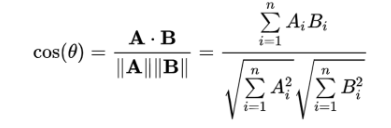

코사인 유사도는 위 수식과 같이 두 벡터를 내적한 뒤, 길이의 곱으로 나눈 값이다. Q, K가 특정 태스크 수행에 중요 역할을 한다면, 트랜스포머는 해당 내적 값을 키우는 방향으로 학습하게 될 것이다.

sequence의 길이가 길더라도 self-attention 모듈을 적용하여 sequence 내 각 단어를 인코딩 벡터로 만들게 되면, 현재 보고자 하는 단어와 이의 인코딩 벡터를 구할 때 참고하는 단어 사이의 time step이 굉장히 멀다고 하더라도 현재의 query vector와 참고하는 단어의 key vector 간의 유사도가 높으면 해당 단어에 관한 정보를 손쉽게 가져올 수 있는 장점이 있다.

In [ ]:
class ScaledDotproductAttention(nn.Module):
  def __init__(self):
    super(ScaledDotproductAttention, self).__init__()

    self.softmax = nn.Softmax()

  def forward(self, q, k, v, mask=None, e=1e-12):
    batch_size, num_head, length, d_k = k.size()
    k_t = torch.view(batch_size, num_head, d_k, length)
    score = (q @ k_t) / math.sqrt(d_k)

    if mask is not None:
      score = score.masked_fill(mask ==0, -e)

    score = self.softmax(score)
    v = score @ v

    return v, score

## Multi-head attention

sequence가 주어졌을 때도 특정한 query word에 관해서로 다른 기준으로 여러 관점에서의 정보를 뽑아와야 할 필요성이 있다.  예를 들어, 문장에서 어떤 주어가 되는 대상이 한 행동 중심의 정보를 뽑아와야 할 뿐더러, 주체가 있는 장소에 관한 정보도 뽑아 올 필요가 있다.

그런데 기존의 One-Head Attention 기법은 어떤 한 단어가 다른 단어와 상호작용하는 정보를 한 가지 방법으로 뽑아올 수 밖에 없다. 그래서 head를 여러 개 두어서 좀 더 다양한 관점에서의 정보를 얻는 과정을 병렬적으로 수행하고자 하는 목적에서 Multi-Head Attention이 사용된다.

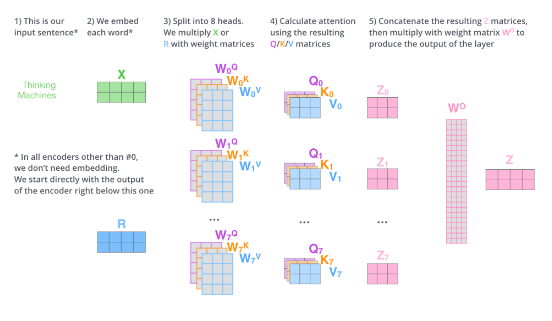

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_head):
    super(MultiHeadAttention, self).__init__()

    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)
    self.w_concat = nn.Linear(d_model, d_model)
    self.attention = ScaledDotproductAttention()

  def split(self, tensor):
    batch_size, head, length, d_model = tensor.size()

    d_k = d_model // self.n_head
    tensor = tensor.view(batch_size, self.n_head, length, d_k)
    return tensor

  def concat(self, tensor):
    batch_size, head, length, d_k = tensor.size()
    d_model = head * d_k

    tensor = tensor.view(batch_size, length, d_model)
    return tensor

  def forward(self,q,k,v,mask=None):
    q,k,v = self.w_q(q), self.w_k(k), self.w_v(v)
    q,k,v = self.split(q), self.split(k), self.split(v)

    temp1, attention = self.attention(q,k,v,mask=mask)
    temp2 = self.concat(temp1)
    output = self.w_concat(output)
    return output

## Normalization

학습을 안정화시키는 역할을 하며, 우리가 원하는 평균과 분산을 주입할 수 있도록 만드는 선형변환을 행한다.

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self,d_model,eps = 1e-12):
        super(LayerNorm,self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self,x):
        mean = x.mean(-1,keepdim = True)
        std = x.std(-1,keepdim = True)
        # '-1' means last dimension

        out = (x-mean)/(std + self.eps)
        out = self.gamma * out + self.beta

        return out

## FFN

input과 동일한 shape를 가진 output을 내면서 ReLU함수를 통해 representation을 높인다. 선형적 연산인 self-attention의 결과에 각 feature에 대한 표현력을 높이기 위해 non-linearty를 반영한다.

In [ ]:
class FFN(nn.Module):
  def __init__(self, d_model, hidden, drop):
    super(FFN, self).__init__()

    self.lr1 = nn.Linear(d_model, hidden)
    self.lr2 = nn.Linear(hidden, d_model)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=drop)

  def forward(self, x):
    temp1 = self.lr1(x)
    temp1 = self.relu(x)
    temp1 = self.dropout(x)
    result = self.lr2(x)
    return result

## Residual connection

Residual Connection의 기본 concept는 어떠한 function을 통해 변환된 x의 값을 원래의 x값과 더하는 것이며, 이는 학습이 진행됨에 따라 input x가 원래의 의미를 잃지 않도록 하기 위함이다.

또한, Deep neural network는 backpropagation을 통해 각 node의 gradient를 구한 뒤 사전에 정의한 optimizer를 이용해 각 parameter를 업데이트 하는데, 층이 너무 깊어 깊은 층에 있는 레이어까지 기울기가 제대로 전파되지 못해 parameter의 학습이 이루어지지 않는 문제를 갖고 있다. ( **Vanishing Gradient** )

Transformer의 경우 역전파가 이루어지는 동안 신호는 활성화 함수와 곱해지게 되는데, ReLU의 경우 대략 절반을 0으로 만들게 된다. 이에 따라 residual connection이 없다면 신호가 제대로 보존되지 않을 것이다. 이에 따라 레이어를 건너 뜀으로서 깊은 층까지 gradient가 보존되도록 하여, parameter의 업데이트가 제대로 수행될 수 있도록 하는 역할을 수행한다. (**Skip-connection**)

In [ ]:
class EncoderLayer(nn.Module):
  def __init__(self, d_model, n_head, hidden, drop):
    super(EncoderLayer, self).__init__()

    self.attention = MultiHeadAttention(d_model, n_head)
    self.norm = LayerNorm(d_model)
    self.dropout = nn.Dropout(drop)
    self.ffn = FFN(d_model, hidden, drop)

  def forward(self, x, src_mask):
    res1_x = x
    x = self.attention(q=x, k=x, v=x, mask=src_mask)
    norm1_x = self.norm(res1_x + x)
    x = self.dropout(norm1_x)

    res2_x = x
    x = self.ffn(x)
    norm2_x = self.norm(res2_x + x)
    x = self.dropout(norm2_x)

    return x

In [ ]:
class Encoder(nn.Module):
  def __init__(self, voc_size, d_model, hidden, n_layers, n_head, seq_len, drop, device):
    super(Encoder, self).__init__()

    self.embed = nn.Embedding(num_embeddings = voc_size, embed_dim=d_model, padding_idx=1)
    self.pe = PE(seq_len, d_model)
    self.layers = nn.ModuleList([Encoder(d_model=d_model, n_head=n_head, hidden=hidden, drop=drop) for _ in range(n_layers)])

  def forward(self, x, src_mask):
    x = self.embed(x)
    pe_x = self.pe(x)
    x = x + pe_x
    for layer in self.layers:
      x = layer(x, src_mask)

    return x

# Decoder

input이 domain에 따라 encoder의 input과 seq_len이 다를 수 있다.

매 time step마다 해당 time step 이후의 단어는 masking한채로 유사도를 단어의 유사도를 구한다. masking을 하는 이유는 앞 단어의 인코딩 벡터가 뒤의 정보를 반영하지 않도록 하기 위함으로, attention score를 0으로 설정한다

( Q, K의 행렬 곱 시 뒤의 time step 이후의 정보가 포함되지 않도록 하기 위함 )

Ground Truth 문장의 각 단어의 임베딩 벡터에 관해 인코딩된 벡터이다

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self, d_model, n_head, hidden, drop):
    super(DecoderLayer, self).__init__()

    self.masked_attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
    self.norm = LayerNorm(d_model=d_model)
    self.dropout = nn.Dropout(drop)

    self.cross_attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
    self.ffn = FFN(d_model=d_model, hidden=hidden, drop=drop)

  def forward(self, x_dec, enc, trg_mask, src_mask):
    res1_x = x_dec
    x_dec = self.masked_attention(q=x_dec, k=x_dec, v=x_dec, mask=trg_mask)
    x = self.norm(res1_x + x_dec)
    x = self.dropout(x)

    if enc is not None:
      res2_x = x
      x = self.cross_attention(q=x, k=enc, v=enc, mask=src_mask)
      x = self.norm(res2_x + x)
      x = self.dropout(x)

    res3_x = x
    x = self.ffn(x)
    x = self.norm(res3_x + x)
    x = self.dropout(x)

    return x

Ground truth 문장의 각 단어가 Source 문장의 어떤 단어와 관련이 높은가 학습한다. encoder로부터 인코딩된 벡터가 K, V / decoder로부터 인코딩도니 벡터가 Q로 사용된다.

이는 ground truth의 각 단어가 encoder의 입력 단어들 중 어떤 단어에 더 주목할지 (관련이 높은지 ) 구하고, 모든 단어들에 대한 관련도를 계산 후 가중합을 통해 정보가 종합된 행렬을 구한다

 ⇒ 해당 벡터값은 선형 변환 layer를 거쳐 softmax를 통해 어떤 단어가 올 것인지 결정되게 된다

이에 따라 예측 단어가 실제 ground truth 문장의 단어가 나오도록 오차를 줄이는 방향으로 학습이 이루어진다. 이것이 decoding time의 한 step이며, decoder의 input sequence만큼 해당 과정을 반복하게 된다

In [ ]:
class Decoder(nn.Module):
  def __init__(self, voc_size, d_model, seq_len, hidden, n_head, n_layer, drop, device):
    super(Decoder, self).__init__()

    self.embed = nn.Embedding(num_embeddings=voc_size, embedding_dim=d_model, padding_idx=1)
    self.pe = PE(seq_len=seq_len, d_model=d_model, device='cuda')
    self.layers = nn.ModuleList([DecoderLayer(d_model=d_model, n_head=n_head, hidden=hidden, drop=drop) for _ in range(n_layer)])
    self.lr = nn.Linear(d_model, voc_size)
    self.softmax = nn.Softmax()

  def forward(self, x, trg_mask, src_mask):
    x = self.embed(x)
    pe_x = self.pe(x)
    x = x + pe_x

    for layer in self.layers:
      x = layer(x, trg_mask, src_mask)

    x = self.lr(x)
    output = self.softmax(x)

    return output

In [ ]:
class Transformer(nn.Module):
    def __init__(self,src_pad_idx,trg_pad_idx,trg_sos_idx,enc_voc_size,dec_voc_size,d_model,n_head,max_len, ffn_hidden,n_layers,drop_prob,device):
        super().__init__()

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.trg_sos_idx = trg_sos_idx

        self.encoder = Encoder(enc_voc_size = enc_voc_size, max_len = max_len, d_model = d_model, ffn_hidden = ffn_hidden,  n_head = n_head,
                               n_layers = n_layers, drop_prob = drop_prob, device = device)
        self.decoder = Decoder(dec_voc_size = dec_voc_size, max_len = max_len, d_model = d_model, ffn_hidden = ffn_hidden, n_head = n_head,
                               n_layers = n_layers, drop_prob = drop_prob, device = device)
        self.device = device

    def make_pad_mask(self,q,k):
        len_q,len_k = q.size(1),k.size(1)
        print(len_k)

        k = k.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        print(k.shape)

        k = k.repeat(1,1,len_q,1)
        q = q.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(3)
        q = q.repeat(1,1,1,len_k)

        mask = k & q

        return mask

    def make_no_peak_mask(self,q,k):
        len_q,len_k = q.size(1),k.size(1)
        mask = torch.tril(torch.ones(len_q,len_k)).type(torch.BoolTensor).to(self.device)

        return mask

    def forward(self,src,trg):
        src_mask = self.make_pad_mask(src,src)
        src_trg_mask = self.make_pad_mask(trg,src)
        trg_mask = self.make_pad_mask(trg,trg) * self.make_no_peak_mask(trg,trg)
        enc_src = self.encoder(src,src_mask)
        output = self.decoder(trg,enc_src,trg_mask,src_trg_mask)

        return output